## Deformable Mirrors

prysm supports deformable mirrors in a broadly PROPER-esque way, but the inputs and semantics are by design different.  In this how-to guide, we will go over the basics of deformable mirrors, as well as the nuances of the inputs and how to achieve the desired behavior.

Because it is of essential importance, we will note at the top:

- influence functions should peak at 1.0 unless you know what you've chosen to have that not be the case

- the overall scaling of things is such that, when the influence function peaks at 1.0, an input of `5` in the actuators array produces a surface height of 5.0 at the center of the actuator.


Moving on; as always we begin with imports,

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from prysm.experimental.dm import DM
from prysm import coordinates, geometry

The approach used by prysm to model a DM surface is to construct a (relatively highly) oversampled lattice of delta functions, which have user-specified height.  That lattice is convolved with a single influence function, assumed to be valid for the entire array of actuators.  The basic inputs to create a new `DM` are:

- the influence function
- the number of actuators in each of the X and Y axes
- the separation of the actuators in the array containing the lattice, in units of samples or 'pixels'

We'll assemble the inputs for a model of a DM with the following specifications:

- 50 x 50 actuators
- a pitch of 1/2 mm
- an influence function which is a sinc function with first zero of the pitch
- four samples per pitch in the array used for the lattice

From those parameters, we can compute the following:

- the center-to-center separation between left and rightmost actuators is 25.0 mm
- with 8 samples per pitch, the sampling increment is 1/16 mm
- if we want some empty space around the DM in our array, at least one characteristic width of the sinc being needed for the convolutional approach to be valid, we need at least 50*16 = 400 x 400 sized arrays (round up to 512)

That information is used to build the inputs:

In [2]:
nact = 50
act_pitch = 0.5
samples_per_act = 8
sampling_pitch = act_pitch / samples_per_act

x, y = coordinates.make_xy_grid(512, dx=sampling_pitch)
influence_func = np.sinc(x/act_pitch) * np.sinc(y/act_pitch)

With these we can construct a simplest DM:

In [3]:
dm = DM(influence_func, nact, samples_per_act, rot=(0,0,0))

Rotation will be covered further below.  For now we model the DM unrotated.

### Interacting with the DM model

To interact with the DM, you will use two steps:

1) modify the `actuators` attribute when you want to adjust the actuator commands

2) call `dm.render()` when you want to retrieve a surface figure error or optical path error map

We'll poke one actuator as a simple example:

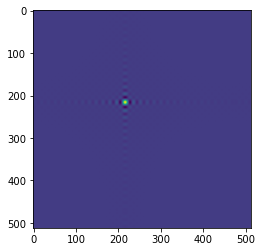

In [4]:
dm.actuators[20, 20] = 1
sfe = dm.render(wfe=False)
plt.imshow(sfe)

Without shifts or tilts, the center of the array is always the `N//2`th actuator, which we can confirm by plotting some slices through a return of a poke of that actuator:

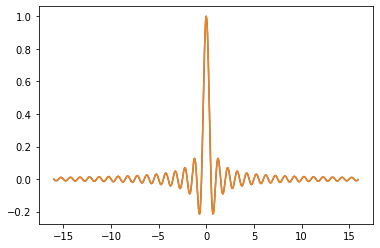

In [5]:
dm.actuators[:] = 0
dm.actuators[25,25] = 1
sfe = dm.render(False)
plt.plot(x[0], sfe[256, :])
plt.plot(y[:, 0], sfe[:, 256])

That the two traces are identical and peak at 1.0 (the height of the command) shows that the array is exactly centered on actuator `[25,25]`, or `[50//2, 50//2]`.

A more interesting example is to have the DM try to recreate some polynomial basis.  For purposes of this tutorial, we will simply draw a very low resolution version of the polynomial we want to make and apply that to the actuators.  We'll use a Q2D or Forbes polynomial basis, since they go approximately to zero at the edge of the unit circle, a favorable property for DMs which are often 'weaker' at the edges of the aperture:

In [6]:
from prysm import polynomials

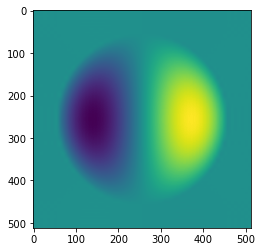

In [7]:
xx, yy = coordinates.make_xy_grid(nact, dx=2/nact)
r, t = coordinates.cart_to_polar(xx, yy)
mode = polynomials.Q2d(1,1,r,t)
mask = geometry.circle(1, r)
mode[~mask] = 0
dm.actuators[:] = mode
plt.imshow(dm.render(False))

From this polynomial recreation example, you can see how to issue a more complex commadn which affects all of the actuators simultaneously.

### Advanced Topics

We will now move on from the basics of interacting with a DM model to advanced topics.


#### Shifts, Rotations, Alignment

The first two on list will be the `shift` and `rot` keyword arguments to `DM`.  If you wish to shift where the surface is drawn, pass a nonzero shift, which uses the same units as x and y.  The shift cannot be modified after `DM` construction.

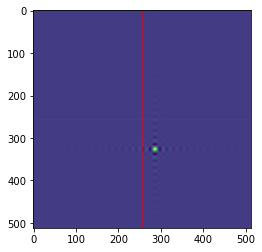

In [8]:
dm2 = DM(influence_func, nact, samples_per_act, rot=(0,0,0), shift=(30.1,70))
dm2.actuators[25,25] = 1
plt.imshow(dm2.render(False))
plt.axvline(256, c='r', lw=0.5)
plt.axhline(256, c='r', lw=0.5)

The shift is implemented using the Fourier shift theorem and is integrated into the convolution step.  It is not subject to quantization.  The sign convention is that positive numbers shift in advancing X and advancing Y.  When using `plt.imshow` _without_ `origin='lower'`, this will appear as a right-downward shift.  With origin lower, it will appear as a right-upward shift.  It may be easier to remember as "positive shift is in the direction of `dm.actuators[-1,-1]`.

If you want to make the DM oblique, pass a nonzero `rot`, which has units of degrees.  The angles are the Tait-Bryan extrinsic angles, for more information see the `coordinates.make_rotation_matrix` docstring.  A rotation about Y is the third angle, about X is the second, and clocking (roll) is the first.  The clocking angle is in the counter-clockwise direction.  We'll use large angles for purposes of clarity in the example:

Text(0.5, 1.0, 'clocking')

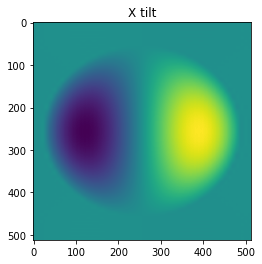

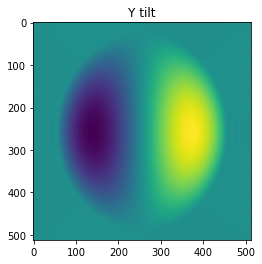

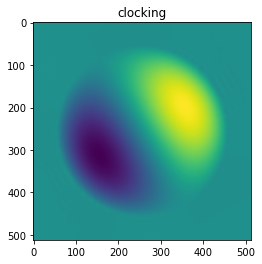

In [9]:
dm2 = DM(influence_func, nact, samples_per_act, rot=(0,0,30), shift=(0,0))
dm2.actuators[:] = mode
plt.imshow(dm2.render(False))
plt.title('X tilt')

dm2 = DM(influence_func, nact, samples_per_act, rot=(0,30,0), shift=(0,0))
dm2.actuators[:] = mode
plt.figure()
plt.imshow(dm2.render(False))
plt.title('Y tilt')

dm2 = DM(influence_func, nact, samples_per_act, rot=(30,0,0), shift=(0,0))
dm2.actuators[:] = mode
plt.figure()
plt.imshow(dm2.render(False))
plt.title('clocking')

There is a potentially unexpected interaction between `shift != 0`, and `rot != 0`.  The rotations are about the (N//2+1) sample (i.e., the "FFT center").

You can see that the data has moved downward and to the right in addition to the clocking applied.  The shift is applied during the convolution, which essentially means the shift happens along the `rot[0]` axis and created complicated interactions:

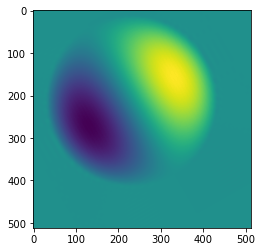

In [10]:
dm2 = DM(influence_func, nact, samples_per_act, rot=(30,0,0), shift=(0,-50))
dm2.actuators[:] = mode
plt.imshow(dm2.render(False))

### Z Scaling

When `wfe=False`, the returns are all surface figure errors.   **When wfe=True, the return represents optical path difference, and the obliquity of the DM is included in the scaling**.  Most programs (PROPER, POPPY) assume `wfe=2*sfe`, but this is not correct.  The implementation in prysm correctly includes the bulk obliquity, but stops shy of using its raytracing module to find the actual surface normal at each point, since it is minutely different from the surface normal of a plane.  The negative sign picked up in reflection is not included for the sake of maintaining consistency with at least the sign convention chosen by other programs.

If you need to maintain compatibility with other programs which do not include obliquity, simply do `sfe = dm.render(False); sfe *= 2`.

----

#### Inline resampling

The penultimate topic is how to handle when the desired output size of the maps and the needed sizes for the convolution differ.  For example, you may have measured influence functions at some particular sampling which you don't want to resample, but the sampling is not the same as is needed for the beams in your model.  This is handled using the `upsample` keyword argument.  The model we have used thusfar has a `512x512` array size, `400x400` of which is the center-to-center separation between the first and last actuator in each dimension.  Suppose we wanted the beam diameter to be `256x256`, and the array size to be `512x512`.  To accomplish this, adjust as follows:

In [11]:
from prysm import fttools

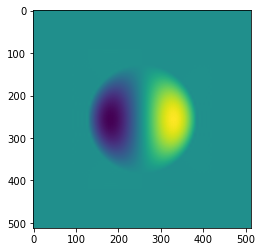

In [12]:
dm2 = DM(influence_func, nact, samples_per_act, rot=(0,0,0), shift=(0,0), upsample=256/400)
dm2.actuators[:] = mode
sfe = dm2.render(False)
sfe = fttools.pad2d(sfe, out_shape=512)
plt.imshow(sfe)

Note that in this case, `upsample < 1`.  This is not a problem.


#### Masks

The final topic is simply masks.  Masks are used to restrict which actuators can actually be moved.  This is a subtle effect.  For example, consider our existing DM; the mask includes all actuators since none was specified.  We can replicate this explicitly:

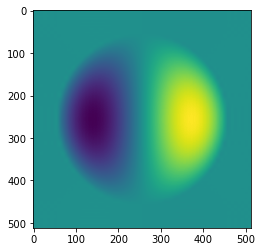

In [13]:
mask=np.ones((50,50), dtype=bool)
dm2 = DM(influence_func, nact, samples_per_act, rot=(0,0,0), shift=(0,0), mask=mask)
dm2.actuators[:] = mode
plt.imshow(dm2.render(False))

Now we will restrict the mask to only the center 10x10 actuators and piston "every" actuator:

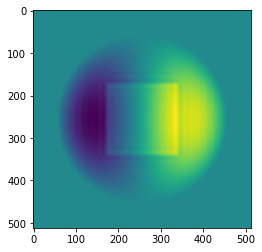

In [14]:
xx, yy = coordinates.make_xy_grid(50, dx=1)
mask = geometry.rectangle(10, xx, yy) # True = active, False = inactive
dm2.mask = mask
dm2.actuators += 0.1
plt.imshow(dm2.render(False))

You can see only those actuators which are within the mask moved, and the other actuators stayed still.  This is a useful way to implement stuck actuators, since they can be set to their stuck position and then masked out.  However, if the stuck actuator list changes over time, the accumulation of state is a subtle business, which you may want to avoid.  The `dm.actuators_work` array contains the actual array of actuator commands (50x50 in this case) which are used in convolution.  The dm code internally simply does `dm.actuators_work[dm.mask] = dm.actuators[dm.mask]` when `render()` is called.

If you don't care about stuck actuators, you may wish to simply mask to a radius a bit larger than your beam, and let the actuators outside remain at the default value of 0.  Or ignore masking, and handle it entirely within writes you make to `dm.actuators`.

----

In this lengthy how-to, we have covered all of the essential information for working with deformable mirrors in prysm.  As is visible in the import, DMs are imported from the `experimental` quarantine, which means they have no testing or API stability guarantees.  The API that is implemented today is a little rough arround the edges, especially around the interaction between `x, y, shift, rot`.  However, the accuracy and flexilbility of the algorithms, as well as their speed, are good and will stay.  If you feel that something is missing, please open a pull request to update this page.  Or, just as well, if you have an idea for a better API, please do open an issue to start the discussion